In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from src.model import Discriminator, Generator
from src.trainer import GAN

In [4]:
mnist = torchvision.datasets.MNIST(
    "../data", train=True, transform=transforms.ToTensor(), download=True
)
# transform = transforms.Compose(
#     [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]

# )
# mnist = torchvision.datasets.MNIST(
#     "../data", train=True, transform=transform, download=True
# )

In [5]:
train_loader = DataLoader(mnist, batch_size=128, shuffle=True)

### CLEARInfoVAE

In [6]:
from src.trainer import CLEARInfoGAN

In [7]:
model = CLEARInfoGAN(
    z_dim=100,
    num_classes=10,
    lr=2e-4,
    hyperparam={"lambda_info": 0.5, "tau": 0.3},
    verbose_period=2,
    device=device
)

In [8]:
d_losses, g_losses, q_losses = model.fit(13, train_loader)

Epoch 12: 100%|██████████| 469/469 [00:14<00:00, 32.09batch/s, d_loss=1.11, g_loss=1.4, loss_c=0.223, loss_s=0.109, q_loss=0.0888]   


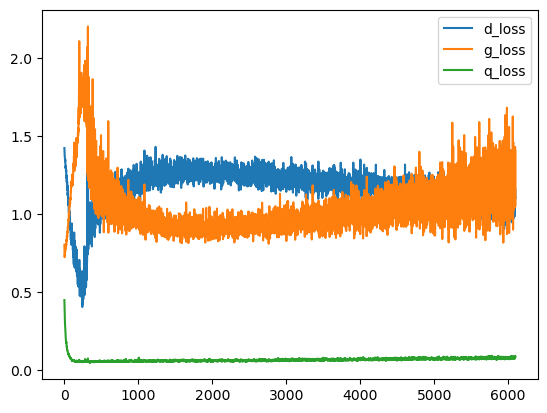

In [9]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses, "q_loss": q_losses}
).plot(kind="line")
plt.show()

In [10]:
model.generator.eval()
z_cs = []
labels = []

samples = []
with torch.no_grad():
    for i in range(10):
        digit_type = (torch.ones(16, dtype=torch.int64) * i).to(model.device)
        torch.manual_seed(1)
        z_raw = torch.randn(16, model.z_dim).to(model.device)
        label_onehot = nn.functional.one_hot(digit_type, 10).to(model.device)
        z_c = model.zc_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z_s = model.zs_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z = torch.cat([z_c, z_s], dim=1)[:, :, None, None]
        xhat = model.generator(z).detach().cpu()
        samples.append(xhat)
        z_cs.append(z_c)
        labels.append(digit_type)
z_cs = torch.cat(z_cs, dim=0)
labels = torch.cat(labels, dim=0)

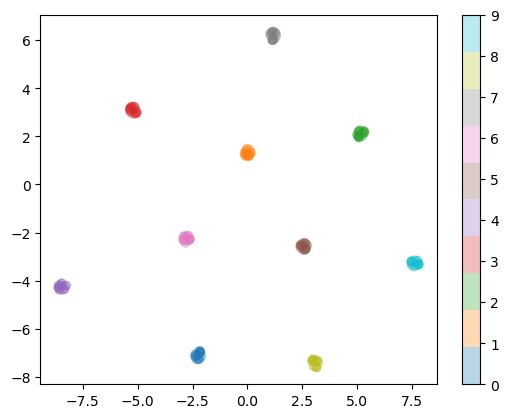

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_cs_tsne = tsne.fit_transform(z_cs.cpu().numpy())
plt.scatter(z_cs_tsne[:, 0], z_cs_tsne[:, 1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')

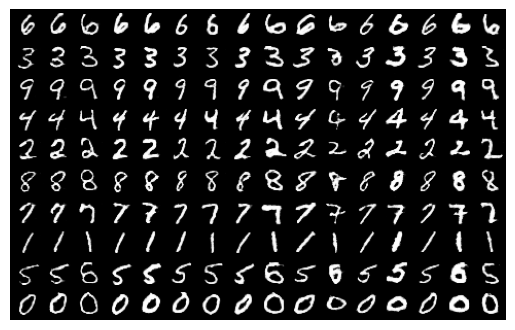

In [12]:
plt.imshow(torch.permute(make_grid(torch.cat(samples, dim=0), nrow=16), (1, 2, 0)))
plt.axis('off')
plt.show()
